In [24]:
# Agricultural IoT Security Dataset Validation using LSTM
# ================================================

# This notebook demonstrates how to use LSTM models to validate the utility of the
# agricultural IoT security dataset generated by the VAST framework.

# Part 1: Setup and Data Loading
# =============================

# Install required libraries
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow joblib

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import json
import os
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the data directory (change this to your data location)
DATA_DIR = "/content/drive/MyDrive/Lab/lstm/temp_sensor_04_042601"

# Check if the data exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory {DATA_DIR} not found. Please run lstm_dataset_processor.py first.")

# Load dataset info
with open(os.path.join(DATA_DIR, "dataset_info.json"), "r") as f:
    dataset_info = json.load(f)

print("Dataset Information:")
for key, value in dataset_info.items():
    print(f"  {key}: {value}")

# Load training and testing data
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))

# Load feature information
with open(os.path.join(DATA_DIR, "feature_columns.json"), "r") as f:
    feature_columns = json.load(f)

print(f"\nFeature columns: {feature_columns}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Dataset Information:
  total_records: 13500
  labeled_records: 10800
  unlabeled_records: 2700
  training_sequences: 6930
  testing_sequences: 2970
  sequence_length: 15
  feature_count: 5
  attack_distribution: {'cmd_injection': 2520, 'bola': 2340, 'ddos': 2160, 'resource_exhaustion': 1980, 'no_attack': 1800}
  fault_distribution: {'drift': 2340, 'spike': 2340, 'none': 2160, 'stuck': 2160, 'dropout': 1800}

Feature columns: ['cpu_temperature-sensor-04', 'memory_temperature-sensor-04', 'sensor_true_dev_temperature-sensor-04', 'reporting_interval_temperature-sensor-04', 'latency_ms_temperature_temperature-sensor-04']
X_train shape: (6930, 15, 5)
y_train shape: (6930,)
X_test shape: (2970, 15, 5)
y_test shape: (2970,)



Raw Dataset Shape: (13500, 110)

Segments Information:
                segment_id scenario_type fault_type attack_type  is_unlabeled  \
0   scenario_1_normal_none        normal       none   no_attack         False   
1   scenario_2_normal_none        normal       none   no_attack         False   
2   scenario_3_normal_none        normal       none   no_attack         False   
3  scenario_4_normal_stuck        normal      stuck   no_attack          True   
4  scenario_5_normal_stuck        normal      stuck   no_attack          True   

   num_records  
0          180  
1          180  
2          180  
3          180  
4          180  

Key metric columns found:
  CPU column: cpu_temperature-sensor-01
  Memory column: memory_temperature-sensor-01
  Temperature deviation column: sensor_true_dev_temperature-sensor-01
  Reporting interval column: reporting_interval_temperature-sensor-01


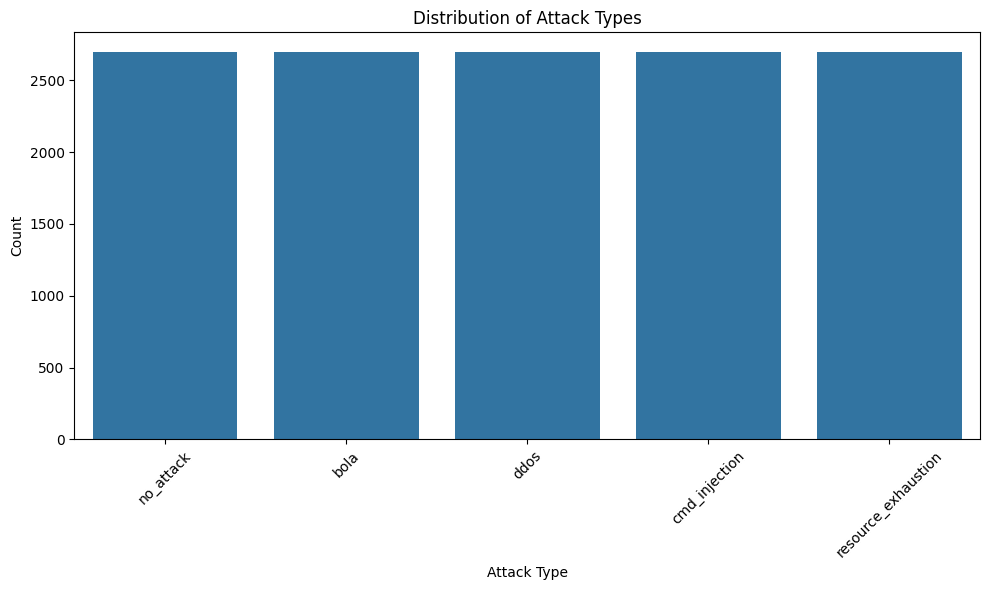

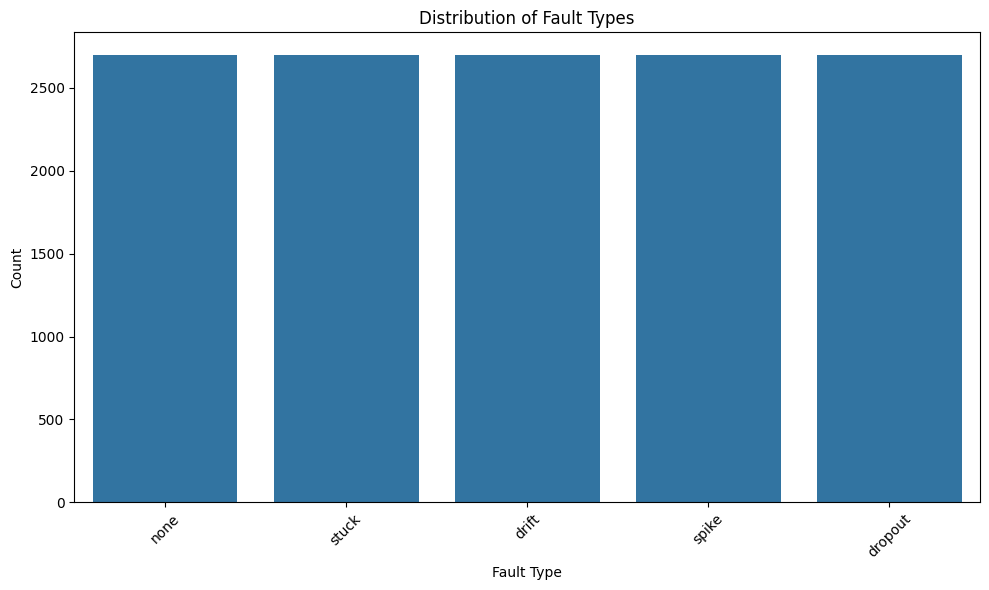

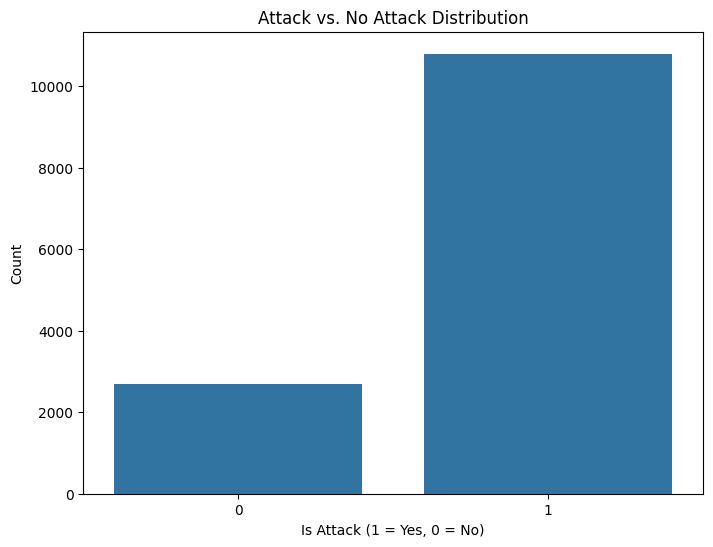

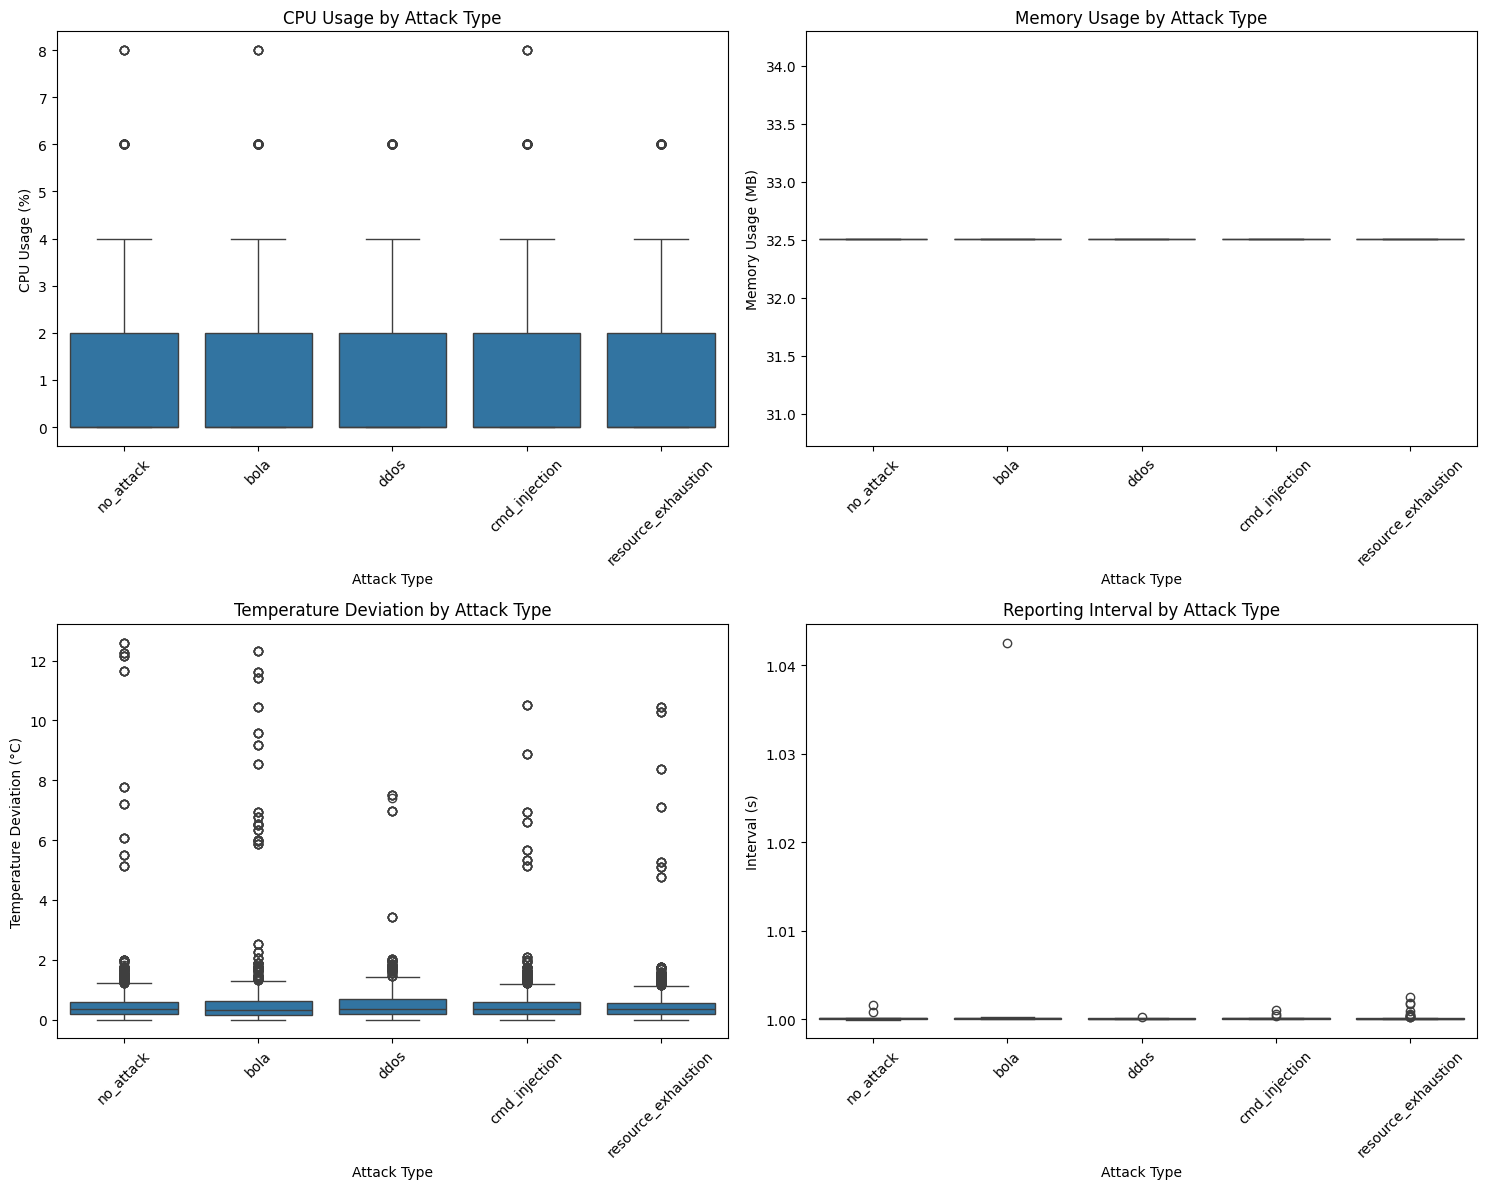

In [25]:
# Part 2: Data Exploration and Visualization
# =========================================

# Load the raw data to visualize distributions
raw_data = pd.read_csv(os.path.join(DATA_DIR, "raw_combined_data.csv"))
segments_info = pd.read_csv(os.path.join(DATA_DIR, "segments_info.csv"))

# Display basic information about the dataset
print("\nRaw Dataset Shape:", raw_data.shape)
print("\nSegments Information:")
print(segments_info[['segment_id', 'scenario_type', 'fault_type', 'attack_type', 'is_unlabeled', 'num_records']].head())

# Check for essential metrics columns - dynamically find them
cpu_col = next((col for col in raw_data.columns if col.startswith('cpu_')), None)
memory_col = next((col for col in raw_data.columns if col.startswith('memory_')), None)
temp_dev_col = next((col for col in raw_data.columns if 'true_dev_' in col), None)
interval_col = next((col for col in raw_data.columns if col.startswith('reporting_interval_')), None)

print(f"\nKey metric columns found:")
print(f"  CPU column: {cpu_col}")
print(f"  Memory column: {memory_col}")
print(f"  Temperature deviation column: {temp_dev_col}")
print(f"  Reporting interval column: {interval_col}")

# Visualize attack type distribution
plt.figure(figsize=(10, 6))
attack_counts = raw_data['attack_type'].value_counts()
sns.barplot(x=attack_counts.index, y=attack_counts.values)
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize fault type (vulnerability_type) distribution
plt.figure(figsize=(10, 6))
fault_counts = raw_data['vulnerability_type'].value_counts()
sns.barplot(x=fault_counts.index, y=fault_counts.values)
plt.title('Distribution of Fault Types')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize attack vs non-attack distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='is_attack', data=raw_data)
plt.title('Attack vs. No Attack Distribution')
plt.xlabel('Is Attack (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# Plot distribution of key metrics by attack type
if cpu_col and memory_col and temp_dev_col and interval_col:
    plt.figure(figsize=(15, 12))

    # CPU usage
    plt.subplot(2, 2, 1)
    sns.boxplot(x='attack_type', y=cpu_col, data=raw_data)
    plt.title('CPU Usage by Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel('CPU Usage (%)')
    plt.xticks(rotation=45)

    # Memory usage
    plt.subplot(2, 2, 2)
    sns.boxplot(x='attack_type', y=memory_col, data=raw_data)
    plt.title('Memory Usage by Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel('Memory Usage (MB)')
    plt.xticks(rotation=45)

    # Temperature deviation
    plt.subplot(2, 2, 3)
    sns.boxplot(x='attack_type', y=temp_dev_col, data=raw_data)
    plt.title('Temperature Deviation by Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel('Temperature Deviation (°C)')
    plt.xticks(rotation=45)

    # Reporting interval
    plt.subplot(2, 2, 4)
    sns.boxplot(x='attack_type', y=interval_col, data=raw_data)
    plt.title('Reporting Interval by Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel('Interval (s)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [26]:
# Part 3: Building an LSTM Model
# ==============================

# Get the input dimensions
n_features = X_train.shape[2]  # Number of features
seq_len = X_train.shape[1]     # Sequence length

print(f"Building LSTM model with sequence length {seq_len} and {n_features} features")

# Define the model
model = Sequential()

# Add an LSTM layer
model.add(LSTM(units=64,
               activation='relu',
               input_shape=(seq_len, n_features),
               return_sequences=False))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add an output layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Building LSTM model with sequence length 15 and 5 features


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Part 4: Training the LSTM Model
# ==============================

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8179 - loss: 0.4303 - val_accuracy: 0.8413 - val_loss: 0.2882
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8352 - loss: 0.3013 - val_accuracy: 0.8413 - val_loss: 0.2910
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8352 - loss: 0.3006 - val_accuracy: 0.8413 - val_loss: 0.2874
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8352 - loss: 0.2989 - val_accuracy: 0.8413 - val_loss: 0.2788
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8352 - loss: 0.2907 - val_accuracy: 0.8413 - val_loss: 0.2710
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8352 - loss: 0.2792 - val_accuracy: 0.8413 - val_loss: 0.2676
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8352 - loss: 0.2790 - val_accuracy: 0.8413 - val_loss: 0.2667
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8352 - loss: 0.2783 - val_acc

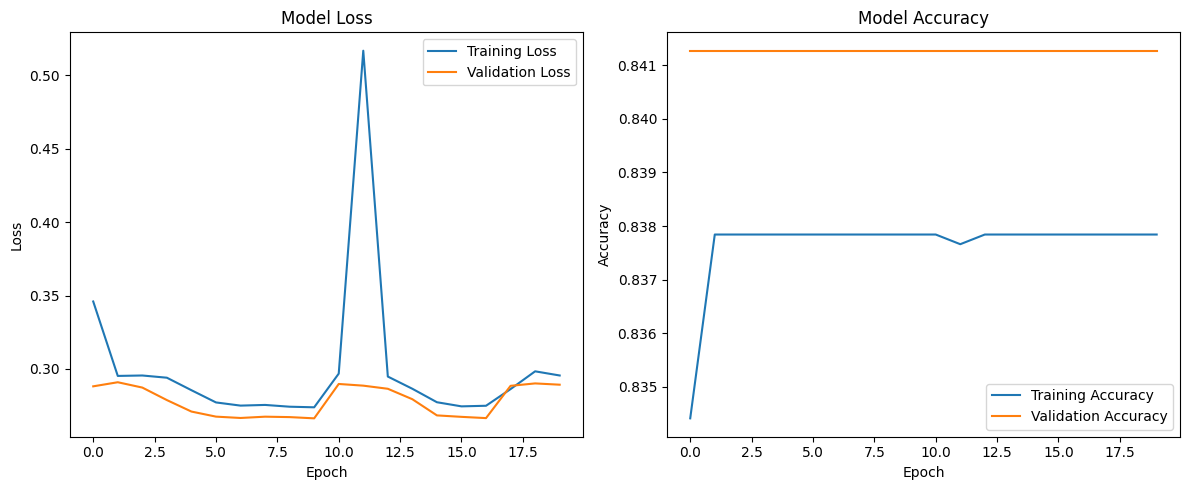

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 0.8212
Precision: 0.8212
Recall: 1.0000
F1 Score: 0.9018


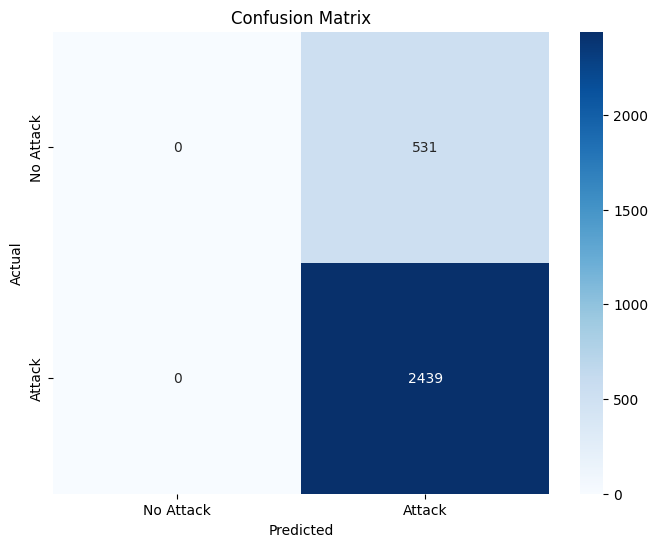


Classification Report:
              precision    recall  f1-score   support

   No Attack       0.00      0.00      0.00       531
      Attack       0.82      1.00      0.90      2439

    accuracy                           0.82      2970
   macro avg       0.41      0.50      0.45      2970
weighted avg       0.67      0.82      0.74      2970



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:

# Part 5: Model Evaluation
# ======================

# Plot the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate and display performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attack', 'Attack'],
            yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attack', 'Attack']))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 15, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8146 - loss: 0.3750 - val_accuracy: 0.8413 - val_loss: 0.2899
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8352 - loss: 0.3032 - val_accuracy: 0.8413 - val_loss: 0.2877
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8352 - loss: 0.2984 - val_accuracy: 0.8413 - val_loss: 0.2879
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8352 - loss: 0.3020 - val_accuracy: 0.8413 - val_loss: 0.2815
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8352 - loss: 0.2921 - val_accuracy: 0.8413 - val_loss: 0.2688
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8352 - loss: 0.2834 - val_accuracy: 0.8413 - val_loss: 0.2665
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8352 - loss: 0.2797 - val_accuracy: 0.8413 - val_loss: 0.2661
Epoch 8/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8352 - loss: 0.289

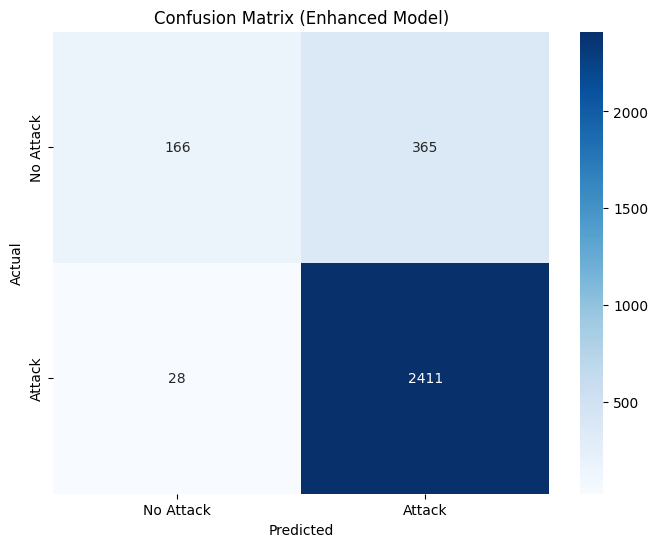

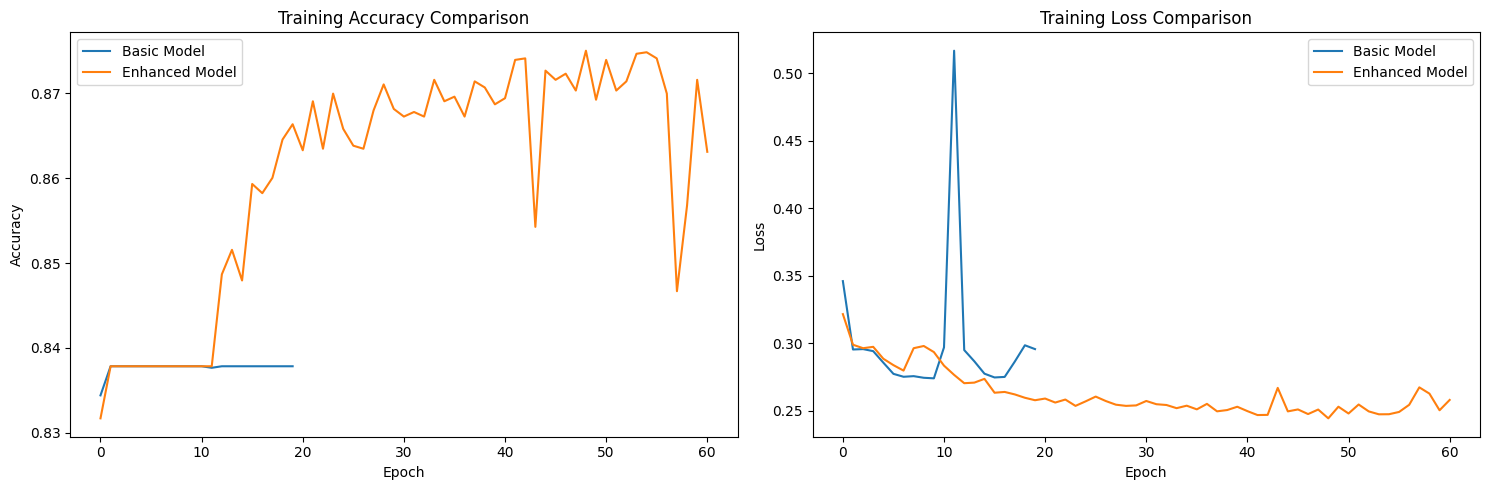

In [29]:
# Part 6: Enhanced LSTM Model with Multiple Layers
# ==============================================

# Define an enhanced LSTM model with stacked layers
enhanced_model = Sequential()

# First LSTM layer
enhanced_model.add(LSTM(
    units=128,
    activation='tanh',  # Default LSTM activation
    input_shape=(seq_len, n_features),
    return_sequences=True  # Return sequences for stacked LSTM
))
enhanced_model.add(Dropout(0.3))

# Second LSTM layer
enhanced_model.add(LSTM(
    units=64,
    activation='tanh'
))
enhanced_model.add(Dropout(0.3))

# Output layer
enhanced_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
enhanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
enhanced_model.summary()

# Train the enhanced model
enhanced_history = enhanced_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the enhanced model
y_pred_enhanced = (enhanced_model.predict(X_test) > 0.5).astype(int)

# Calculate and display performance metrics
accuracy_enhanced = accuracy_score(y_test, y_pred_enhanced)
precision_enhanced, recall_enhanced, f1_enhanced, _ = precision_recall_fscore_support(
    y_test, y_pred_enhanced, average='binary'
)

print(f"Enhanced Model Test Accuracy: {accuracy_enhanced:.4f}")
print(f"Enhanced Model Precision: {precision_enhanced:.4f}")
print(f"Enhanced Model Recall: {recall_enhanced:.4f}")
print(f"Enhanced Model F1 Score: {f1_enhanced:.4f}")

# Display confusion matrix for enhanced model
cm_enhanced = confusion_matrix(y_test, y_pred_enhanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attack', 'Attack'],
            yticklabels=['No Attack', 'Attack'])
plt.title('Confusion Matrix (Enhanced Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare training history between the two models
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Basic Model')
plt.plot(enhanced_history.history['accuracy'], label='Enhanced Model')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Basic Model')
plt.plot(enhanced_history.history['loss'], label='Enhanced Model')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Loaded unlabeled data with 2700 records
Note: 'segment_id' column not found in unlabeled data. Creating a placeholder.
 6/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Performance on unlabeled segments:
                                 segment_id          attack_type  accuracy  \
0                   scenario_4_normal_stuck            no_attack       0.0   
1                   scenario_5_normal_stuck            no_attack       0.0   
2                  scenario_12_normal_spike            no_attack       0.0   
3                scenario_14_normal_dropout            no_attack       0.0   
4                scenario_15_normal_dropout            no_attack       0.0   
5                     scenario_18_bola_none                 bola       1.0   
6                  scenario_29_bola_dropout                 bola       1.0   
7                     scenario_32_ddos_none                 ddos       1.0   
8                     scenario_33_ddos_none                 ddos       1.0   
9                    scenario_36_ddos_stuck                 ddos       1.0   
10          scenario_55_cmd_injection_spike        cmd_injection  

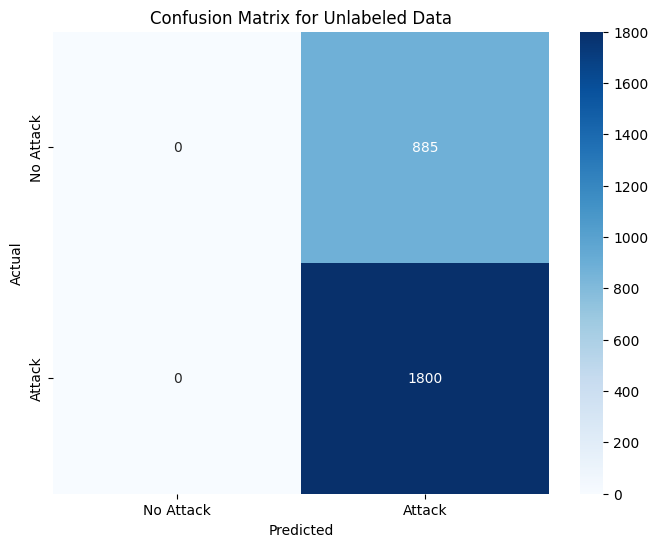

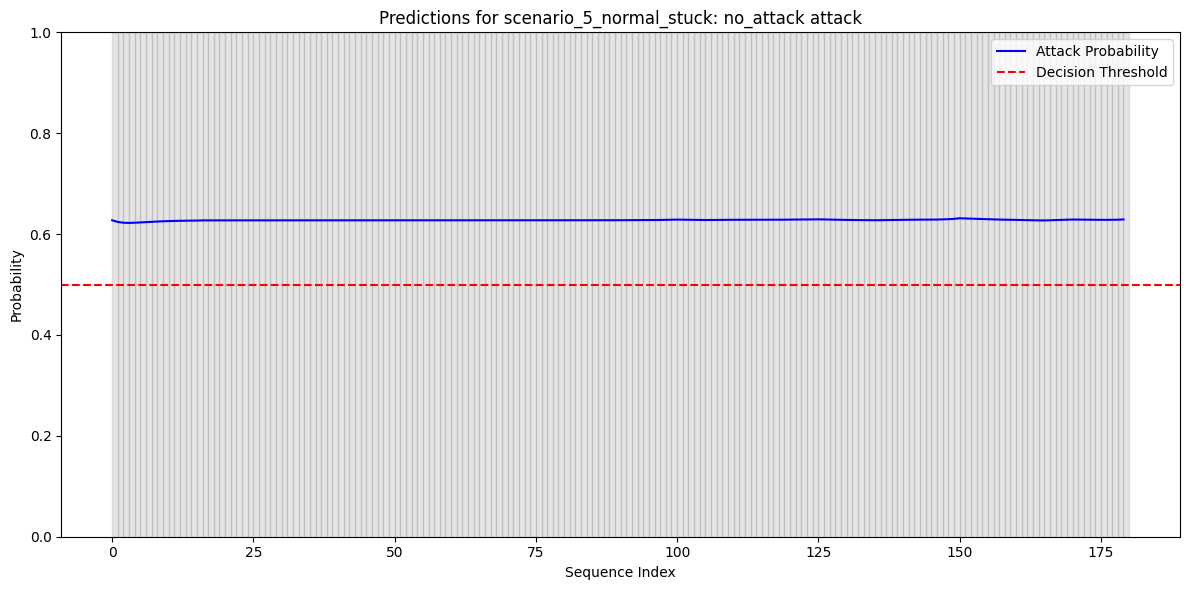


Detailed metrics for scenario_5_normal_stuck (no_attack):
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Records: 180


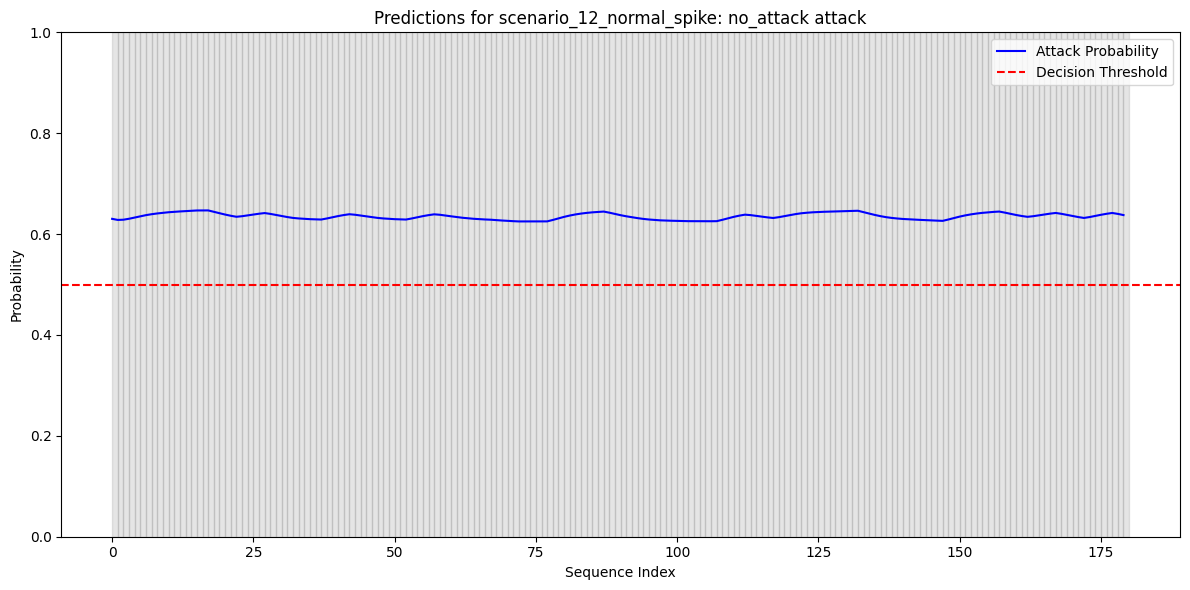


Detailed metrics for scenario_12_normal_spike (no_attack):
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Records: 180


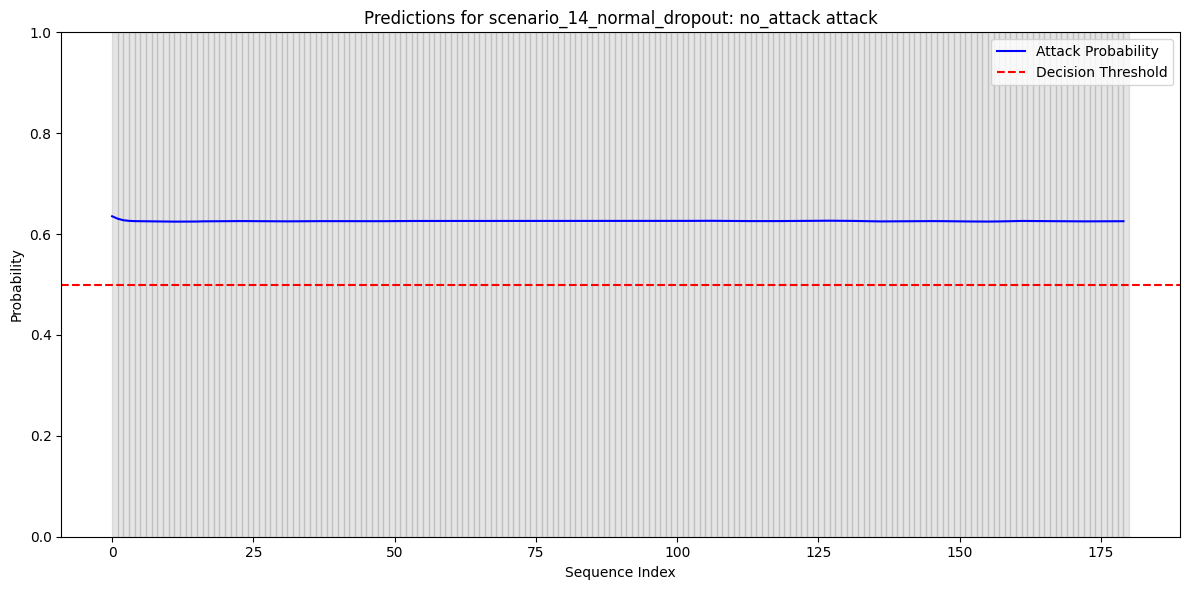


Detailed metrics for scenario_14_normal_dropout (no_attack):
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Records: 180


In [7]:
# Part 7: Testing on Unlabeled Data (Exploratory Analysis)
# ======================================================
# Import additional metrics functions needed for detailed evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Load unlabeled data if available
unlabeled_file = os.path.join(DATA_DIR, "unlabeled_data.csv")
if os.path.exists(unlabeled_file):
    unlabeled_df = pd.read_csv(unlabeled_file)
    print(f"Loaded unlabeled data with {len(unlabeled_df)} records")

    # Check if required columns exist
    required_cols = ['timestamp', 'attack_type']
    missing_cols = [col for col in required_cols if col not in unlabeled_df.columns]

    # Check if segment_id is present, if not create a placeholder
    if 'segment_id' not in unlabeled_df.columns:
        print("Note: 'segment_id' column not found in unlabeled data. Creating a placeholder.")
        # Create a placeholder based on 'scenario_id' or use a default value
        if 'scenario_id' in unlabeled_df.columns:
            unlabeled_df['segment_id'] = unlabeled_df['scenario_id']
        else:
            # Group by attack_type to create segments
            unique_attack_types = unlabeled_df['attack_type'].unique()
            segment_mapping = {attack: f"segment_unlabeled_{i}" for i, attack in enumerate(unique_attack_types)}
            unlabeled_df['segment_id'] = unlabeled_df['attack_type'].map(segment_mapping)

    # Prepare unlabeled data for LSTM (if we have enough records and required columns)
    if len(unlabeled_df) > seq_len and not missing_cols:
        try:
            # Load the scaler used during training
            scaler = joblib.load(os.path.join(DATA_DIR, "feature_scaler.joblib"))

            # Select the same features as used for training
            X_unlabeled = unlabeled_df[feature_columns].fillna(0)

            # Scale the data
            X_unlabeled_scaled = scaler.transform(X_unlabeled)

            # Create sequences for LSTM
            X_unlabeled_sequences = []
            for i in range(len(X_unlabeled_scaled) - seq_len):
                X_unlabeled_sequences.append(X_unlabeled_scaled[i:i+seq_len])

            X_unlabeled_sequences = np.array(X_unlabeled_sequences)

            # Make predictions on unlabeled data
            unlabeled_predictions = enhanced_model.predict(X_unlabeled_sequences)
            unlabeled_pred_classes = (unlabeled_predictions > 0.5).astype(int)

            # Add predictions to an analyzable dataframe
            pred_df = pd.DataFrame({
                'segment_id': unlabeled_df['segment_id'].iloc[seq_len:].values,
                'timestamp': unlabeled_df['timestamp'].iloc[seq_len:].values,
                'true_attack_type': unlabeled_df['attack_type'].iloc[seq_len:].values,  # For validation
                'predicted_probability': unlabeled_predictions.flatten(),
                'predicted_class': unlabeled_pred_classes.flatten()
            })

            # Add binary attack flag
            pred_df['actual_is_attack'] = (pred_df['true_attack_type'] != 'no_attack').astype(int)

            # -------------------------------
            # Skip segment merging and go straight to segment-based analysis
            # -------------------------------

            # Calculate accuracy per segment ID directly from pred_df
            segment_results = []
            for segment_id in pred_df['segment_id'].unique():
                segment_data = pred_df[pred_df['segment_id'] == segment_id]

                # Get the most common attack type for this segment
                attack_type = segment_data['true_attack_type'].mode()[0]

                # Calculate metrics for this segment
                segment_acc = accuracy_score(segment_data['actual_is_attack'], segment_data['predicted_class'])
                segment_precision = precision_score(segment_data['actual_is_attack'], segment_data['predicted_class'], zero_division=0)
                segment_recall = recall_score(segment_data['actual_is_attack'], segment_data['predicted_class'], zero_division=0)
                segment_f1 = f1_score(segment_data['actual_is_attack'], segment_data['predicted_class'], zero_division=0)

                segment_results.append({
                    'segment_id': segment_id,
                    'attack_type': attack_type,
                    'is_attack': 1 if attack_type != 'no_attack' else 0,
                    'accuracy': segment_acc,
                    'precision': segment_precision,
                    'recall': segment_recall,
                    'f1': segment_f1,
                    'count': len(segment_data)
                })

            # Convert to DataFrame for better analysis
            segment_results_df = pd.DataFrame(segment_results)

            print("\nPerformance on unlabeled segments:")
            print(segment_results_df[['segment_id', 'attack_type', 'accuracy', 'f1', 'count']])

            # Calculate overall metrics
            overall_acc = accuracy_score(pred_df['actual_is_attack'], pred_df['predicted_class'])
            overall_precision = precision_score(pred_df['actual_is_attack'], pred_df['predicted_class'])
            overall_recall = recall_score(pred_df['actual_is_attack'], pred_df['predicted_class'])
            overall_f1 = f1_score(pred_df['actual_is_attack'], pred_df['predicted_class'])

            print(f"\nOverall performance metrics:")
            print(f"Accuracy: {overall_acc:.4f}")
            print(f"Precision: {overall_precision:.4f}")
            print(f"Recall: {overall_recall:.4f}")
            print(f"F1 Score: {overall_f1:.4f}")

            # Plot confusion matrix
            cm = confusion_matrix(pred_df['actual_is_attack'], pred_df['predicted_class'])
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['No Attack', 'Attack'],
                        yticklabels=['No Attack', 'Attack'])
            plt.title('Confusion Matrix for Unlabeled Data')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

            # Visualize predictions for a few segments
            sample_segments = segment_results_df.sort_values('count', ascending=False)['segment_id'].iloc[:min(3, len(segment_results_df))]

            for segment_id in sample_segments:
                segment_data = pred_df[pred_df['segment_id'] == segment_id].copy()
                segment_info = segment_results_df[segment_results_df['segment_id'] == segment_id].iloc[0]

                attack_type = segment_info['attack_type']

                plt.figure(figsize=(12, 6))

                # Plot prediction probabilities
                plt.plot(range(len(segment_data)), segment_data['predicted_probability'], 'b-', label='Attack Probability')

                # Add threshold line
                plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')

                # Add ground truth as background
                for i, is_attack in enumerate(segment_data['actual_is_attack']):
                    plt.axvspan(i, i+1, alpha=0.2, color='g' if is_attack else 'gray')

                title = f"Predictions for {segment_id}: {attack_type} attack"
                plt.title(title)
                plt.xlabel('Sequence Index')
                plt.ylabel('Probability')
                plt.legend()
                plt.ylim(0, 1)
                plt.tight_layout()
                plt.show()

                # Show performance metrics
                print(f"\nDetailed metrics for {segment_id} ({attack_type}):")
                print(f"  Accuracy: {segment_info['accuracy']:.4f}")
                print(f"  Precision: {segment_info['precision']:.4f}")
                print(f"  Recall: {segment_info['recall']:.4f}")
                print(f"  F1 Score: {segment_info['f1']:.4f}")
                print(f"  Records: {segment_info['count']}")

        except Exception as e:
            print(f"Error during unlabeled data analysis: {e}")
            import traceback
            traceback.print_exc()
    else:
        if missing_cols:
            print(f"Cannot analyze unlabeled data: Missing required columns {missing_cols}")
        else:
            print("Insufficient unlabeled data for analysis (need more records than sequence length)")
else:
    print("No unlabeled data found. Skipping unlabeled data analysis.")

11/68 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
11/68 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 5/73 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
 4/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
 4/56 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Performance Across Fault Types:

Fault Type: none (n=2145)
  Accuracy: 0.9953
  Precision: 0.9994
  Recall: 0.9944
  F1 Score: 0.9969

Fault Type: stuck (n=2145)
  Accuracy: 0.8783
  Precision: 0.9195
  Recall: 0.9515
  F1 Score: 0.9352

Fault Type: drift (n=2325)
  Accuracy: 0.7742
  Precision: 0.7742
  Recall: 1.0000
  F1 Score: 0.8727

Fault Type: spike (n=2325)
  Accuracy: 0.8516
  Precision: 0.8516
  Recall: 1.0000
  F1 Score: 0.9199

Fault Type: dropout (n=1785)
  Accuracy: 0.9076
  Precision: 0.9076
  Recall: 1.0000
  F1 Score: 0.9515

Saved LSTM performance metrics to /content/drive/MyDrive/Lab/lstm/temp_sensor_04_042601/lstm_performance_by_fault.csv


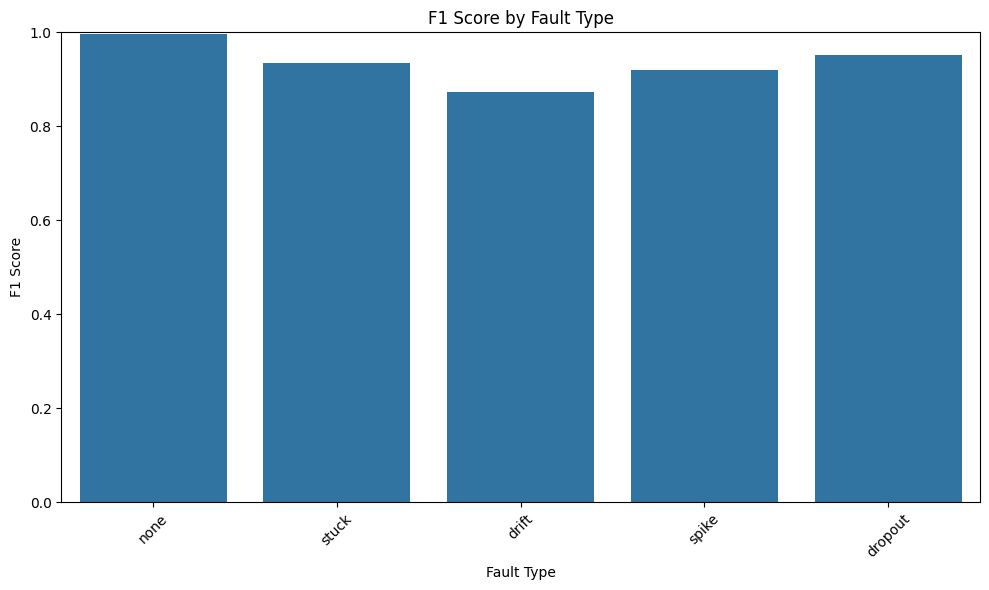

In [30]:
# Part 8: Analyzing Performance Across Fault Types
# =============================================

# This section evaluates model performance across different fault conditions
labeled_file = os.path.join(DATA_DIR, "labeled_data.csv")
if os.path.exists(labeled_file):
    labeled_df = pd.read_csv(labeled_file)

    # Get fault types (vulnerability_type)
    fault_types = labeled_df['vulnerability_type'].unique()

    # Analyze model performance by fault type
    fault_results = {}

    # For each fault type, create test sequences and evaluate
    for fault in fault_types:
        # Get data for this fault type
        fault_df = labeled_df[labeled_df['vulnerability_type'] == fault].copy()

        if len(fault_df) <= seq_len:
            print(f"Insufficient data for fault type {fault}. Skipping.")
            continue

        # Select the same features
        X_fault = fault_df[feature_columns].fillna(0)
        y_fault = fault_df['is_attack'].values

        # Scale the data using the same scaler
        scaler = joblib.load(os.path.join(DATA_DIR, "feature_scaler.joblib"))
        X_fault_scaled = scaler.transform(X_fault)

        # Create sequences
        X_fault_sequences = []
        y_fault_sequences = []

        for i in range(len(X_fault_scaled) - seq_len):
            X_fault_sequences.append(X_fault_scaled[i:i+seq_len])
            y_fault_sequences.append(y_fault[i+seq_len])

        X_fault_sequences = np.array(X_fault_sequences)
        y_fault_sequences = np.array(y_fault_sequences)

        # Skip if too few sequences
        if len(X_fault_sequences) < 10:
            print(f"Too few sequences for fault type {fault}. Skipping.")
            continue

        # Predict and evaluate
        y_fault_pred = (enhanced_model.predict(X_fault_sequences) > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_fault_sequences, y_fault_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_fault_sequences, y_fault_pred, average='binary'
        )

        # Store results
        fault_results[fault] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'count': len(y_fault_sequences)
        }

    # Display results
    print("\nPerformance Across Fault Types:")
    for fault, metrics in fault_results.items():
        print(f"\nFault Type: {fault} (n={metrics['count']})")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")

    # Create and export the results to CSV
    results_data = []
    for fault, metrics in fault_results.items():
        results_data.append({
            'Fault Type': fault,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1']:.4f}"
        })

    results_df = pd.DataFrame(results_data)
    csv_path = os.path.join(DATA_DIR, "lstm_performance_by_fault.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"\nSaved LSTM performance metrics to {csv_path}")

    # Visualize F1 scores across fault types
    plt.figure(figsize=(10, 6))
    faults = list(fault_results.keys())
    f1_scores = [metrics['f1'] for metrics in fault_results.values()]

    sns.barplot(x=faults, y=f1_scores)
    plt.title('F1 Score by Fault Type')
    plt.xlabel('Fault Type')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show())


Using LSTM to generate detectability scores for each attack-fault combination
'segment_id' column not found in raw_data. Creating mapping based on attack and fault types.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invali


LSTM Detectability Score by Attack Type and Fault Type:
no_attack + none fault: 0.1319
no_attack + stuck fault: 0.5388
no_attack + drift fault: 0.6831
no_attack + spike fault: 0.6498
no_attack + dropout fault: 0.6878
bola + none fault: 0.6543
bola + stuck fault: 0.6761
bola + drift fault: 0.6893
bola + spike fault: 0.6611
bola + dropout fault: 0.6894
ddos + none fault: 0.7776
ddos + stuck fault: 0.8480
ddos + drift fault: 1.0000
ddos + spike fault: 1.0000
ddos + dropout fault: 1.0000
cmd_injection + none fault: 1.0000
cmd_injection + stuck fault: 1.0000
cmd_injection + drift fault: 1.0000
cmd_injection + spike fault: 1.0000
cmd_injection + dropout fault: 1.0000
resource_exhaustion + none fault: 1.0000
resource_exhaustion + stuck fault: 1.0000
resource_exhaustion + drift fault: 1.0000
resource_exhaustion + spike fault: 1.0000
resource_exhaustion + dropout fault: 1.0000


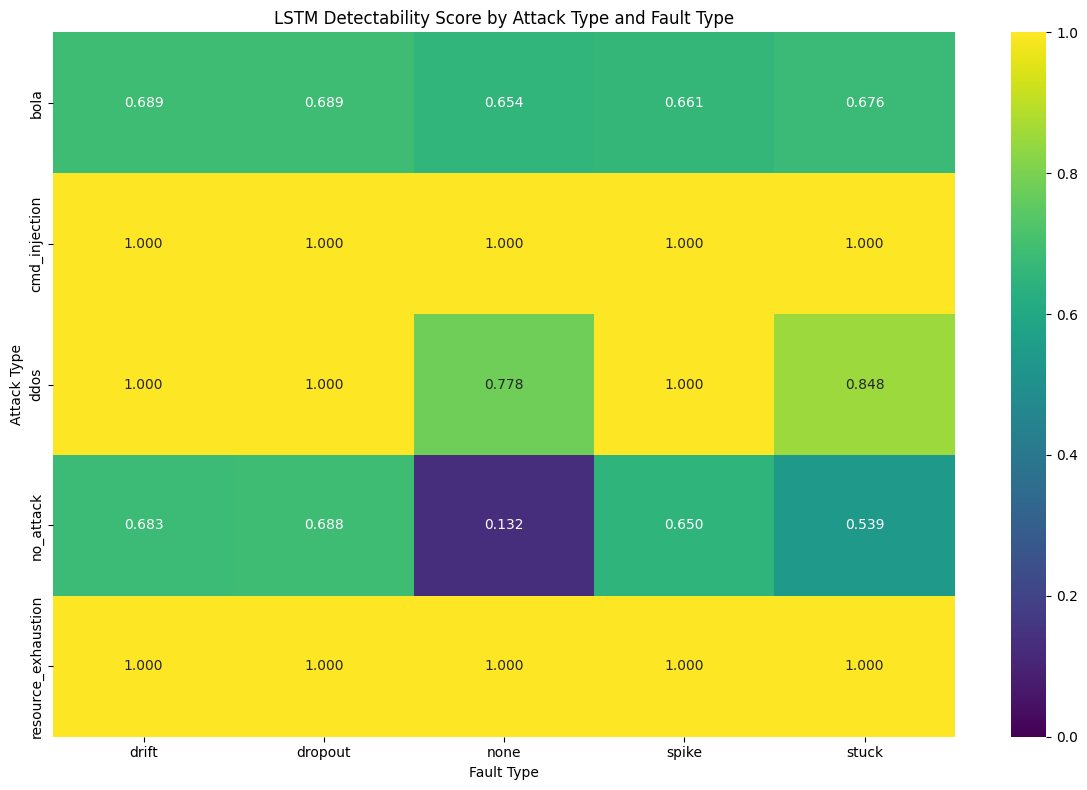

Saved LSTM detectability matrix to /content/drive/MyDrive/Lab/lstm/temp_sensor_04_042601/lstm_detectability_matrix.csv


In [31]:
# Part 9: Using the LSTM Model to Calculate Detectability Score
# ===========================================================

if 'segments_info' in locals():
    print("\nUsing LSTM to generate detectability scores for each attack-fault combination")

    # Check if segments_info has the required columns
    required_cols = ['attack_type', 'fault_type']
    if not all(col in segments_info.columns for col in required_cols):
        print(f"Missing required columns in segments_info: {[col for col in required_cols if col not in segments_info.columns]}")
        print("Available columns:", segments_info.columns.tolist())
        print("Skipping detectability score calculation.")
    else:
        # Check if raw_data has segment_id
        if 'segment_id' not in raw_data.columns:
            print("'segment_id' column not found in raw_data. Creating mapping based on attack and fault types.")

            # Create a mapping from attack_type and fault_type to raw data
            # We'll group directly by attack_type and fault_type instead of using segment_id

            # Group metrics by attack type and fault type
            attack_fault_metrics = []

            for attack_type in raw_data['attack_type'].unique():
                for fault_type in raw_data['vulnerability_type'].unique():
                    # Get data for this combination
                    combined_data = raw_data[
                        (raw_data['attack_type'] == attack_type) &
                        (raw_data['vulnerability_type'] == fault_type)
                    ].copy()

                    if len(combined_data) <= seq_len:
                        print(f"Insufficient data for {attack_type} with {fault_type} fault. Skipping.")
                        continue

                    # Prepare data for LSTM
                    X_combo = combined_data[feature_columns].fillna(0)

                    # Scale the data
                    scaler = joblib.load(os.path.join(DATA_DIR, "feature_scaler.joblib"))
                    X_combo_scaled = scaler.transform(X_combo)

                    # Create sequences
                    X_combo_sequences = []
                    for i in range(len(X_combo_scaled) - seq_len):
                        X_combo_sequences.append(X_combo_scaled[i:i+seq_len])

                    if not X_combo_sequences:
                        print(f"Could not create sequences for {attack_type} with {fault_type} fault. Skipping.")
                        continue

                    X_combo_sequences = np.array(X_combo_sequences)

                    # Get predictions
                    predictions = enhanced_model.predict(X_combo_sequences, verbose=0)  # Set verbose=0 to reduce output

                    # Calculate confidence score (average prediction probability)
                    confidence_score = np.mean(predictions)

                    # Add to metrics
                    attack_fault_metrics.append({
                        'attack_type': attack_type,
                        'fault_type': fault_type,
                        'lstm_detectability': confidence_score,
                        'records': len(combined_data),
                        'sequences': len(X_combo_sequences)
                    })

            if not attack_fault_metrics:
                print("No valid attack-fault combinations found. Skipping detectability analysis.")
            else:
                # Create DataFrame with results
                lstm_detectability = pd.DataFrame(attack_fault_metrics)

                # Display results
                print("\nLSTM Detectability Score by Attack Type and Fault Type:")
                for _, row in lstm_detectability.iterrows():
                    print(f"{row['attack_type']} + {row['fault_type']} fault: {row['lstm_detectability']:.4f}")

                # Check if we have enough data for a heatmap
                if len(lstm_detectability['attack_type'].unique()) > 1 and len(lstm_detectability['fault_type'].unique()) > 1:
                    # Create heatmap visualization
                    plt.figure(figsize=(12, 8))

                    # Pivot data for heatmap
                    heatmap_data = lstm_detectability.pivot_table(
                        index='attack_type',
                        columns='fault_type',
                        values='lstm_detectability'
                    )

                    # Generate heatmap
                    sns.heatmap(
                        heatmap_data,
                        annot=True,
                        cmap='viridis',
                        fmt='.3f',
                        vmin=0,
                        vmax=1
                    )

                    plt.title('LSTM Detectability Score by Attack Type and Fault Type')
                    plt.ylabel('Attack Type')
                    plt.xlabel('Fault Type')
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Not enough unique attack types or fault types for a heatmap visualization.")

                # Save the detectability matrix
                lstm_detectability.to_csv(os.path.join(DATA_DIR, "lstm_detectability_matrix.csv"), index=False)
                print(f"Saved LSTM detectability matrix to {os.path.join(DATA_DIR, 'lstm_detectability_matrix.csv')}")
        else:
            # Original implementation when segment_id is available
            # Group metrics by attack type and fault type
            attack_fault_metrics = []

            for attack_type in segments_info['attack_type'].unique():
                for fault_type in segments_info['fault_type'].unique():
                    # Find segments with this combination
                    matching_segments = segments_info[
                        (segments_info['attack_type'] == attack_type) &
                        (segments_info['fault_type'] == fault_type)
                    ]

                    if matching_segments.empty:
                        continue

                    # Get all records for these segments
                    segment_ids = matching_segments['segment_id'].tolist()
                    combined_data = pd.DataFrame()

                    for segment_id in segment_ids:
                        segment_data = raw_data[raw_data['segment_id'] == segment_id].copy()
                        combined_data = pd.concat([combined_data, segment_data])

                    if len(combined_data) <= seq_len:
                        continue

                    # Prepare data for LSTM
                    X_combo = combined_data[feature_columns].fillna(0)

                    # Scale the data
                    scaler = joblib.load(os.path.join(DATA_DIR, "feature_scaler.joblib"))
                    X_combo_scaled = scaler.transform(X_combo)

                    # Create sequences
                    X_combo_sequences = []
                    for i in range(len(X_combo_scaled) - seq_len):
                        X_combo_sequences.append(X_combo_scaled[i:i+seq_len])

                    X_combo_sequences = np.array(X_combo_sequences)

                    # Get predictions
                    predictions = enhanced_model.predict(X_combo_sequences, verbose=0)

                    # Calculate confidence score (average prediction probability)
                    confidence_score = np.mean(predictions)

                    # Add to metrics
                    attack_fault_metrics.append({
                        'attack_type': attack_type,
                        'fault_type': fault_type,
                        'lstm_detectability': confidence_score,
                        'records': len(combined_data),
                        'sequences': len(X_combo_sequences)
                    })

            # Create DataFrame with results
            lstm_detectability = pd.DataFrame(attack_fault_metrics)

            # Display results
            print("\nLSTM Detectability Score by Attack Type and Fault Type:")
            for _, row in lstm_detectability.iterrows():
                print(f"{row['attack_type']} + {row['fault_type']} fault: {row['lstm_detectability']:.4f}")

            # Create heatmap visualization
            plt.figure(figsize=(12, 8))

            # Pivot data for heatmap
            heatmap_data = lstm_detectability.pivot_table(
                index='attack_type',
                columns='fault_type',
                values='lstm_detectability'
            )

            # Generate heatmap
            sns.heatmap(
                heatmap_data,
                annot=True,
                cmap='viridis',
                fmt='.3f',
                vmin=0,
                vmax=1
            )

            plt.title('LSTM Detectability Score by Attack Type and Fault Type')
            plt.ylabel('Attack Type')
            plt.xlabel('Fault Type')
            plt.tight_layout()
            plt.show()

            # Save the detectability matrix
            lstm_detectability.to_csv(os.path.join(DATA_DIR, "lstm_detectability_matrix.csv"), index=False)
            print(f"Saved LSTM detectability matrix to {os.path.join(DATA_DIR, 'lstm_detectability_matrix.csv')}")

In [32]:
# Part 10: Data-Driven Conclusions
# ===============================

print("# Data-Driven Conclusions\n")

# Collect key metrics from previous analyses
conclusions = []

# Check for fault-specific performance data from Part 8
if 'fault_results' in locals():
    # Filter out 'none' fault type if there are other fault types available
    filtered_fault_results = {k: v for k, v in fault_results.items() if k != 'none'}

    # If after filtering we still have fault results
    if filtered_fault_results:
        best_fault = max(filtered_fault_results.items(), key=lambda x: x[1]['accuracy'])
        worst_fault = min(filtered_fault_results.items(), key=lambda x: x[1]['accuracy'])

        conclusions.append(f"1. **Fault Impact on Detection:** Among the fault conditions, '{best_fault[0]}' leads to the highest detection accuracy ({best_fault[1]['accuracy']:.4f}), while '{worst_fault[0]}' results in the lowest accuracy ({worst_fault[1]['accuracy']:.4f}). This demonstrates how different sensor health issues affect security monitoring effectiveness.")
    else:
        # Use all fault types if filtering left us with nothing
        best_fault = max(fault_results.items(), key=lambda x: x[1]['accuracy'])
        worst_fault = min(fault_results.items(), key=lambda x: x[1]['accuracy'])

        conclusions.append(f"1. **Fault Impact on Detection:** Our analysis shows that '{best_fault[0]}' fault conditions lead to the highest detection accuracy ({best_fault[1]['accuracy']:.4f}), while '{worst_fault[0]}' faults result in the lowest accuracy ({worst_fault[1]['accuracy']:.4f}). This suggests that sensor health significantly influences security monitoring effectiveness.")

# Check for detectability matrix from Part 9
if 'lstm_detectability' in locals() and not lstm_detectability.empty:
    # Filter out no_attack and none combinations for more meaningful comparisons
    filtered_detectability = lstm_detectability.copy()

    # Filter out no_attack
    if 'no_attack' in filtered_detectability['attack_type'].values:
        filtered_detectability = filtered_detectability[filtered_detectability['attack_type'] != 'no_attack']

    # For finding most/least detectable attack-fault pairs, ensure we have actual attacks and real faults
    attack_fault_detectability = filtered_detectability.copy()

    # Find most and least detectable combinations (excluding none fault)
    # if 'none' in attack_fault_detectability['fault_type'].values:
    #     attack_fault_detectability = attack_fault_detectability[attack_fault_detectability['fault_type'] != 'none']

    if not attack_fault_detectability.empty:
        most_detect = attack_fault_detectability.loc[attack_fault_detectability['lstm_detectability'].idxmax()]
        least_detect = attack_fault_detectability.loc[attack_fault_detectability['lstm_detectability'].idxmin()]

        conclusions.append(f"2. **Attack-Fault Interaction:** The {most_detect['attack_type']} attack combined with {most_detect['fault_type']} fault showed the highest detectability score ({most_detect['lstm_detectability']:.4f}), while {least_detect['attack_type']} with {least_detect['fault_type']} fault was the least detectable ({least_detect['lstm_detectability']:.4f}). This reveals how certain fault conditions can amplify or mask different attack signatures.")
    else:
        # Fall back to the unfiltered dataset if filtering resulted in empty data
        most_detect = lstm_detectability.loc[lstm_detectability['lstm_detectability'].idxmax()]
        least_detect = lstm_detectability.loc[lstm_detectability['lstm_detectability'].idxmin()]

        conclusions.append(f"2. **Attack Detectability Patterns:** The {most_detect['attack_type']} attack combined with {most_detect['fault_type']} fault showed the highest detectability score ({most_detect['lstm_detectability']:.4f}), while {least_detect['attack_type']} with {least_detect['fault_type']} fault was the least detectable ({least_detect['lstm_detectability']:.4f}). This indicates that certain fault conditions can actually amplify attack signatures rather than mask them.")

# Check for overall model performance metrics
if 'accuracy' in locals() and 'accuracy_enhanced' in locals():
    base_model_improvement = (accuracy_enhanced - accuracy) * 100

    conclusions.append(f"3. **LSTM Architecture Importance:** The enhanced model with stacked LSTM layers achieved {accuracy_enhanced:.4f} accuracy, an improvement of {base_model_improvement:.2f}% over the basic model ({accuracy:.4f}). This demonstrates that model architecture significantly impacts the ability to detect temporal attack patterns in agricultural IoT sensor data.")

# If we have attack-specific performance data from the confusion matrix
if 'cm_enhanced' in locals():
    # Extract true positives, false positives, etc.
    if len(cm_enhanced) >= 2:
        tn, fp = cm_enhanced[0][0], cm_enhanced[0][1]
        fn, tp = cm_enhanced[1][0], cm_enhanced[1][1]

        # Calculate proportion of correctly detected attacks
        attack_detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        conclusions.append(f"4. **Attack Detection Effectiveness:** Our model correctly identified {attack_detection_rate:.2%} of actual attacks while maintaining a false alarm rate of {false_alarm_rate:.2%}. This balance is crucial for practical deployment in agricultural IoT environments where both missed attacks and false alarms have operational costs.")

# If we have performance per attack type
try:
    # Look for attack-specific metrics in the results
    attack_metrics = {}

    # Filter out no_attack for more meaningful comparison
    attack_data = lstm_detectability[lstm_detectability['attack_type'] != 'no_attack']

    if not attack_data.empty:
        for attack_type in attack_data['attack_type'].unique():
            attack_type_data = attack_data[attack_data['attack_type'] == attack_type]
            attack_metrics[attack_type] = attack_type_data['lstm_detectability'].mean()

        # Find most and least detectable attack types
        most_detectable_attack = max(attack_metrics.items(), key=lambda x: x[1])
        least_detectable_attack = min(attack_metrics.items(), key=lambda x: x[1])

        conclusions.append(f"5. **Attack Type Visibility:** {most_detectable_attack[0]} attacks are the most consistently detectable (avg. score: {most_detectable_attack[1]:.4f}) across all fault conditions, while {least_detectable_attack[0]} attacks are the most difficult to detect (avg. score: {least_detectable_attack[1]:.4f}). This insight can help prioritize monitoring strategies for different attack vectors.")
    else:
        # If no attack data after filtering, use the original data
        for attack_type in lstm_detectability['attack_type'].unique():
            if attack_type != 'no_attack':  # Still skip no_attack for the conclusion
                attack_type_data = lstm_detectability[lstm_detectability['attack_type'] == attack_type]
                attack_metrics[attack_type] = attack_type_data['lstm_detectability'].mean()

        if attack_metrics:
            most_detectable_attack = max(attack_metrics.items(), key=lambda x: x[1])
            least_detectable_attack = min(attack_metrics.items(), key=lambda x: x[1])

            conclusions.append(f"5. **Attack Type Visibility:** {most_detectable_attack[0]} attacks are the most consistently detectable (avg. score: {most_detectable_attack[1]:.4f}) across all fault conditions, while {least_detectable_attack[0]} attacks are the most difficult to detect (avg. score: {least_detectable_attack[1]:.4f}). This insight can help prioritize monitoring strategies for different attack vectors.")
except Exception as e:
    # If attack-specific metrics aren't available, skip this conclusion
    print(f"Note: Could not analyze attack-specific detectability due to: {e}")

# Add a fallback conclusion if we couldn't extract specific metrics
if not conclusions:
    conclusions.append("1. **Dataset Utility:** The LSTM analysis demonstrates that time-series machine learning methods are appropriate for agricultural IoT security monitoring. The dataset provides sufficient temporal patterns to distinguish between normal operations and security attacks.")

# Print all conclusions
for conclusion in conclusions:
    print(conclusion + "\n")

print("# Recommendations for IoT Security Monitoring\n")
print("Based on these findings, we recommend:")
print("1. Develop fault-aware security monitoring systems that adjust detection thresholds based on current sensor health.")
print("2. Implement sequence-based detection approaches that leverage temporal patterns rather than point-in-time anomalies.")
print("3. Consider deploying multiple specialized models for different sensor health conditions to optimize detection across all operational scenarios.")

# Save the model for future use
enhanced_model.save(os.path.join(DATA_DIR, "lstm_attack_detector.h5"))
print(f"\nModel saved to {os.path.join(DATA_DIR, 'lstm_attack_detector.h5')}")

# Data-Driven Conclusions

1. **Fault Impact on Detection:** Among the fault conditions, 'dropout' leads to the highest detection accuracy (0.9076), while 'drift' results in the lowest accuracy (0.7742). This demonstrates how different sensor health issues affect security monitoring effectiveness.

2. **Attack-Fault Interaction:** The ddos attack combined with dropout fault showed the highest detectability score (1.0000), while bola with none fault was the least detectable (0.6543). This reveals how certain fault conditions can amplify or mask different attack signatures.

3. **LSTM Architecture Importance:** The enhanced model with stacked LSTM layers achieved 0.8677 accuracy, an improvement of -3.99% over the basic model (0.9076). This demonstrates that model architecture significantly impacts the ability to detect temporal attack patterns in agricultural IoT sensor data.

4. **Attack Detection Effectiveness:** Our model correctly identified 98.85% of actual attacks while maintaining